In [3]:
import tarfile
local_saving_path = 'model.tar.gz'
with tarfile.open(local_saving_path) as tar:
        tar.extractall(path="bordex_output_gpu")

In [33]:
ls

bordex_output_gpu/  model.tar.gz         prediction.ipynb
loss_model.tar.gz   pred_temp_lm_image/


In [34]:
import tarfile
local_saving_path = 'loss_model.tar.gz'
with tarfile.open(local_saving_path) as tar:
        tar.extractall(path="loss_output_gpu")

In [104]:
!aws codeartifact login --tool pip --repository package-mirror --domain xaas-artifacts --domain-owner 346256573792 --region eu-west-2

Successfully configured pip to use AWS CodeArtifact repository https://xaas-artifacts-346256573792.d.codeartifact.eu-west-2.amazonaws.com/pypi/package-mirror/ 
Login expires in 12 hours at 2024-11-04 23:07:55+00:00


In [18]:
# ! python -m pip install --upgrade pip
# ! pip install torch==1.10.0 torchvision==0.11.1
# ! pip install simpletransformers
# ! pip install transformers==4.26.1
# ! python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html

In [19]:
# !pip install PyPDF2
# !pip install pdf2image

In [20]:
# ! conda install -c conda-forge poppler -y


In [22]:
# !pip install Pillow==9.0.0
# !pip3 install opencv-python-headless==4.5.3.56

In [39]:
# from transformers import AutoTokenizer
# import torch
# from transformers import AutoModelForSequenceClassification
# import pandas as pd
# import os 
# import boto3
# import pandas as pd
# import json

# imports
import boto3
import pandas as pd
import json
import io
import os
from PIL import Image
from transformers import LayoutLMv2Processor, LayoutLMv2ForSequenceClassification
import torch
from pdf2image import convert_from_path

import warnings
warnings.filterwarnings('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [40]:
def get_image(pdf_path, page_no, save_image = False, image_dir=None):
    print('Converting to image')
    images = convert_from_path(pdf_path)
    image = images[page_no-1].resize((762,1000))
    print('Image Conversion Completed!')

    return image

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def ocr_func(image_path):
#     print(f'Image path: {image_path}')
    client =  boto3.client('textract')
    image = Image.open(image_path)
#     print(image.size)
    width, height = image.size

#     print("image.format: ",image.format)

    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format=image.format)
    imgByteArr = imgByteArr.getvalue()

    responses = client.detect_document_text(Document = {"Bytes":imgByteArr})

    left_cor = []
    top_cor = []
    width_cor = []
    height_cor = []
    page = []

    line_text = []

    blocks=responses["Blocks"]
    for block in blocks:
        if (block["BlockType"] == "WORD"):
            left_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Left"]*width)))
            top_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Top"]*height)))
            width_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Width"]*width)))
            height_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Height"]*height)))
            line_text.append((block["Text"]))
    ocr_df = pd.DataFrame(list(zip(left_cor,top_cor,width_cor,height_cor,line_text)),columns = ["left","top","width","height","text"])    
#     print(ocr_df.shape)
#     print('ocr completed.')
    ocr_df['right']=ocr_df['left']+ocr_df['width']
    ocr_df['bottom']=ocr_df['top']+ocr_df['height']
    
    normalized_bboxes=[]
    for row in ocr_df.iterrows():
        row=row[1]
        normalized_bboxes.append(normalize_box([row['left'], row['top'], row['right'], row['bottom']], width, height))
    ocr_df['norm_bbox']=normalized_bboxes
    return ocr_df

def model_inferencing(image_path,processor,words,boxes,model,id2label):
    image = Image.open(image_path)
    image = image.convert("RGB")


    encoding = processor(image,words,boxes=boxes, return_tensors="pt", max_length=512,
                             padding="max_length", truncation=True)
    
#     print("\nEncoding Keys :----",encoding.keys())
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for k,v in encoding.items():
        encoding[k] = v.to(device)
    
    outputs = model(**encoding)
    label = id2label[outputs.logits.argmax(-1).item()]
    return label

In [6]:
PATH_MODEL = '/root/Balram/Layout_page_classification/prediction/bordex_output_gpu/model_page_classification_best.pt'

In [7]:
labels = ['others', 'bordereau']
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
print(label2id)

{'others': 0, 'bordereau': 1}


In [12]:
b_model = LayoutLMv2ForSequenceClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                          num_labels=len(labels))
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
model.load_state_dict(torch.load(PATH_MODEL,map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =",device)
_ = model.to(device)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.10.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.3.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batche

device = cpu


In [ ]:
Balram/Layout_page_classification/prediction/loss_output_gpu/model_page_classification_best.pt

In [7]:
b_images = os.listdir('/root/Balram/Layout_page_classification/script/training_data/images/bordereau/')
len(b_images)

538

In [21]:
a_images = os.listdir('/root/Balram/Layout_page_classification/script/training_data/images/advice/')
len(a_images)

551

In [23]:
image_path = '/root/Balram/Layout_page_classification/script/training_data/images/advice/'+a_images[1]
#image_path = '/root/Balram/Layout_page_classification/script/training_data/images/bordereau/898_PB_28-02-2023_11_57_00__1.jpg'
ocr_df = ocr_func(image_path)
words = ocr_df.text.tolist()
boxes = ocr_df.norm_bbox.tolist()
left =  ocr_df.left.tolist()
top =  ocr_df.top.tolist()
right = ocr_df.right.tolist()
bottom = ocr_df.bottom.tolist()

label = model_inferencing(image_path,processor,words,boxes,model, id2label)
label

'others'

## PDF Prediction

In [8]:
import re

In [9]:
import boto3
import json 
import re
def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]


def ocr_func_from_json(bucket, document):
    #Get the document from S3
    """Extract text from json and return text dict, response, line df, word df.
    modified_date: 7/20/2022,
    modified by: Anshuman"""
    
    s3_connection = boto3.resource("s3")
    
    client = boto3.client('s3')
    
    result = client.get_object(Bucket=bucket, Key=document)
    text = result['Body'].read().decode('utf-8')
    res = json.loads(text)
    
    width, height = 762,1000
    
    #****** WORD ************
    left_cor = []
    top_cor = []
    width_cor = []
    height_cor = []
    page = []
    
    word_text = []
    for response in res:
        blocks=response["Blocks"]
        for block in blocks:
            if (block["BlockType"] == "WORD"):
                left_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Left"]*width)))
                top_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Top"]*height)))
                width_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Width"]*width)))
                height_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Height"]*height)))
                word_text.append((block["Text"]))
                page.append(block["Page"])
    
    df_word = pd.DataFrame(list(zip(left_cor,top_cor,width_cor,height_cor,word_text,page)),columns = ["left","top","width","height","text","page"])    
    df_word["right"] = (df_word["left"] + df_word["width"])
    df_word["bottom"] = (df_word["top"] + df_word["height"])
    
    normalized_bboxes=[]
    for row in df_word.iterrows():
        row=row[1]
        normalized_bboxes.append(normalize_box([row['left'], row['top'], row['right'], row['bottom']], width, height))
    df_word['norm_bbox']=normalized_bboxes
    
    return df_word

In [25]:
labels = ['others', 'bordereau']
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
print(label2id)

{'others': 0, 'bordereau': 1}


In [33]:
pdf_path = '/root/Balram/Layout_page_classification/data_preparation/data/training_data/calculation/2022_Sanctions_confirmation_02-03-2023_09_43_00.pdf'

json_name = re.sub(".pdf|.PDF|.Pdf", ".json", pdf_path.split('/')[-1])
json_path = 'Layout_page_classification/calculation/'+json_name
#json_path = 'Layout_page_classification/acknowledgement/B0180ME2005449_2022-10-10_ME2005449__QS__-_endt_006__agreed__08-12-2021_08_46_00.json'

print(pdf_path)
print(json_path)
df_word = ocr_func_from_json('sagemaker-p-c7qmmnapl7uc', json_path)
total_pages = list(set(df_word['page'].tolist()))
total_pages = total_pages if len(total_pages) <=5 else total_pages[:5]
print("total_pages = ",total_pages)
for page_no in total_pages:
    df_word_temp = df_word[df_word['page']==page_no]
    
    words = df_word_temp.text.tolist()
    boxes = df_word_temp.norm_bbox.tolist()
    page = convert_from_path(pdf_path, 500,size=(762,1000),first_page = page_no,last_page = page_no)
    my_temp_image_path = 'pred_temp_lm_image/temp_'+str(page_no)+'.jpg'
    page[0].save(my_temp_image_path, 'JPEG')
    
    label = model_inferencing(my_temp_image_path,processor,words,boxes,model, id2label)
    print(f"Page_{page_no} = {label}")


/root/Balram/Layout_page_classification/data_preparation/data/training_data/calculation/2022_Sanctions_confirmation_02-03-2023_09_43_00.pdf
Layout_page_classification/calculation/2022_Sanctions_confirmation_02-03-2023_09_43_00.json
total_pages =  [1]
Page_1 = others


In [ ]:
ocr_df = ocr_func(image_path)
words = ocr_df.text.tolist()
boxes = ocr_df.norm_bbox.tolist()


label = model_inferencing(image_path,processor,words,boxes,model, id2label)
label

## Run on Local PDF

In [2]:
def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def ocr_func(image_path):
#     print(f'Image path: {image_path}')
    client =  boto3.client('textract')
    image = Image.open(image_path)
#     print(image.size)
    width, height = image.size

#     print("image.format: ",image.format)

    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format=image.format)
    imgByteArr = imgByteArr.getvalue()

    responses = client.detect_document_text(Document = {"Bytes":imgByteArr})

    left_cor = []
    top_cor = []
    width_cor = []
    height_cor = []
    page = []

    line_text = []

    blocks=responses["Blocks"]
    for block in blocks:
        if (block["BlockType"] == "WORD"):
            left_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Left"]*width)))
            top_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Top"]*height)))
            width_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Width"]*width)))
            height_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Height"]*height)))
            line_text.append((block["Text"]))
    ocr_df = pd.DataFrame(list(zip(left_cor,top_cor,width_cor,height_cor,line_text)),columns = ["left","top","width","height","text"])    
#     print(ocr_df.shape)
#     print('ocr completed.')
    ocr_df['right']=ocr_df['left']+ocr_df['width']
    ocr_df['bottom']=ocr_df['top']+ocr_df['height']
    
    normalized_bboxes=[]
    for row in ocr_df.iterrows():
        row=row[1]
        normalized_bboxes.append(normalize_box([row['left'], row['top'], row['right'], row['bottom']], width, height))
    ocr_df['norm_bbox']=normalized_bboxes
    return ocr_df


def model_inferencing(image_path,processor,words,boxes,model,id2label):
    image = Image.open(image_path)
    image = image.convert("RGB")


    encoding = processor(image,words,boxes=boxes, return_tensors="pt", max_length=512,
                             padding="max_length", truncation=True)
    
#     print("\nEncoding Keys :----",encoding.keys())
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for k,v in encoding.items():
        encoding[k] = v.to(device)
    
    outputs = model(**encoding)
    label = id2label[outputs.logits.argmax(-1).item()]
    return label

In [3]:
import PyPDF2
from pdf2image import convert_from_path
import boto3
from PIL import Image
import io
import pandas as pd
import os



from transformers import LayoutLMv2Processor, LayoutLMv2ForSequenceClassification
import torch

import warnings
warnings.filterwarnings('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# b_PATH_MODEL = '/root/Balram/Layout_page_classification/prediction/bordex_output_gpu/model_page_classification_best.pt'

# b_labels = ['others', 'bordereau']

# b_model = LayoutLMv2ForSequenceClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
#                                                           num_labels=len(b_labels))
# processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
# b_model.load_state_dict(torch.load(b_PATH_MODEL,map_location=torch.device('cpu')))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("device =",device)
# _ = b_model.to(device)

In [5]:
# l_PATH_MODEL = '/root/Balram/Layout_page_classification/prediction/loss_output_gpu/lossrun_model_page_classification_best.pt'

# l_labels = ['others', 'lossrun']

# l_model = LayoutLMv2ForSequenceClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
#                                                           num_labels=len(l_labels))
# processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
# l_model = torch.load(l_PATH_MODEL,map_location=torch.device('cpu'))
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("device =",device)
# _ = l_model.to(device)

In [6]:
ls

bordereau_model_page_classification_best.pt  model.tar.gz
bordex_output_gpu/                           pred_temp_lm_image/
loss_model.tar.gz                            prediction.ipynb
loss_model_page_classification_best.pt       test_data/
loss_output_gpu/


In [7]:
b_model = torch.load('bordereau_model_page_classification_best.pt')

In [6]:
l_model = torch.load('loss_model_page_classification_best.pt')

In [5]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")


In [71]:
!ls 'test_data/'

acknowledgement  advice  bordeau  calculation  lossrun


In [107]:
f_path = '/root/Balram/Layout_page_classification/prediction/test_data/calculation/'
pdfs = os.listdir(f_path)
print(len(pdfs))

8


In [101]:
pdfs[7]

'PREMIUM_FRMARLR20000570033200001_11-01-2021_16_16_00.pdf'

In [8]:
pdf_path = '/root/Balram/Layout_page_classification/prediction/test_data/bordeau/898_SUM_28-02-2023_11_57_00.pdf'

#pdf_path = f_path+Balram/Layout_page_classification/prediction/test_data/bordeau/898_SUM_28-02-2023_11_57_00.pdf

b_labels = ['others', 'bordereau']
b_id2label = {v: k for v, k in enumerate(b_labels)}
print(b_id2label)

pdf_file = open(pdf_path, 'rb')
pdf_reader = PyPDF2.PdfReader(pdf_file)
total_pages_count = len(pdf_reader.pages)

print(pdf_path)
print("Total page counts = ",total_pages_count)
total_pages_count = total_pages_count if total_pages_count <=3 else 3
total_pages = list(range(1,total_pages_count+1))
print("total_pages = ",total_pages)

predictions = []
for page_no in total_pages:

    page = convert_from_path(pdf_path, 500,size=(762,1000),first_page = page_no,last_page = page_no)
    my_temp_image_path = 'pred_temp_lm_image/temp_'+str(page_no)+'.jpg'
    page[0].save(my_temp_image_path, 'JPEG')
    ocr_df = ocr_func(my_temp_image_path)
    words = ocr_df.text.tolist()
    boxes = ocr_df.norm_bbox.tolist()
    
    label = model_inferencing(my_temp_image_path,processor,words,boxes,b_model, b_id2label)
    predictions.append(label)
    print(f"Page_{page_no} = {label}")

from collections import Counter
counter = Counter(predictions)
max_item = counter.most_common(1)[0]
max_item[0]

{0: 'others', 1: 'bordereau'}
/root/Balram/Layout_page_classification/prediction/test_data/bordeau/898_SUM_28-02-2023_11_57_00.pdf
Total page counts =  1
total_pages =  [1]
Page_1 = bordereau


'bordereau'

In [14]:
#pdf_path = '/root/Balram/Layout_page_classification/data_preparation/data/training_data/lossrun/Loss_Run_-_Casino_Miami_LLC-Copy1.PDF'

l_labels = ['others', 'lossrun']
l_id2label = {v: k for v, k in enumerate(l_labels)}
print(l_id2label)

with open(pdf_path, 'rb') as pdf_file:
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    total_pages_count = len(pdf_reader.pages)

print(pdf_path)
print("Total page counts = ",total_pages_count)
total_pages_count = total_pages_count if total_pages_count <=3 else 3
total_pages = list(range(1,total_pages_count+1))
print("total_pages = ",total_pages)

predictions = []
for page_no in total_pages:

    page = convert_from_path(pdf_path, 500,size=(762,1000),first_page = page_no,last_page = page_no)
    my_temp_image_path = 'pred_temp_lm_image/temp_'+str(page_no)+'.jpg'
    page[0].save(my_temp_image_path, 'JPEG')
    ocr_df = ocr_func(my_temp_image_path)
    words = ocr_df.text.tolist()
    boxes = ocr_df.norm_bbox.tolist()
    
    label = model_inferencing(my_temp_image_path,processor,words,boxes,l_model, l_id2label)
    predictions.append(label)
    print(f"Page_{page_no} = {label}")

from collections import Counter
counter = Counter(predictions)
max_item = counter.most_common(1)[0]
max_item[0]

{0: 'others', 1: 'lossrun'}
/root/Balram/Layout_page_classification/data_preparation/data/training_data/lossrun/_10m_x__15m_x_P_-_2020_-_ClaimsLoss_ClaimsPerInterest_-_EG0807020.pdf
Total page counts =  3
total_pages =  [1, 2, 3]
Page_1 = lossrun
Page_2 = lossrun
Page_3 = lossrun


'lossrun'

In [130]:
torch.save(l_model, 'loss_model_page_classification_best.pt')
#torch.save(processor, 'model_token_classification/processor.pt')

In [131]:
torch.save(b_model, 'bordereau_model_page_classification_best.pt')


In [110]:
#  DependencyError: PyCryptodome is required for AES algorithm
#!pip install pycryptodome==3.15.0

In [ ]:
## Test Data
s3://sb-udv3-tenant-1c7ad518-tenantbucket-4js5bpwftyty/Convex-Sprint3-Testing-Data/lossrun/batch_1/

In [ ]:
# check

/root/Balram/Layout_page_classification/prediction/test_data/lossrun/Loss_Record-_NOV23.pdf
/root/Balram/Layout_page_classification/prediction/test_data/lossrun/2_23-24_HPLGL__5M_xs__5M_Quote_-_Scottsdale_as_of_11-9-23.pdf
/root/Balram/Layout_page_classification/prediction/test_data/calculation/CALCULATION_FRENGDO20001040016700001_16-06-2020_17_15_00.pdf


/root/Balram/Layout_page_classification/prediction/test_data/advice/PREMIUM_FRMARLR20000570033200001_11-01-2021_16_16_00.pdf

In [15]:
{'advice': '99.82%',
 'Bordereau': '94.3%', 
 'calculation': '0.3%',
 'Loss Runs': '0.02%', 
 'MRC-Endorsement': '0.04%',
 'MRC Slip': '0.24%', 
 'Proposal_Form': '0.0%'}

## Run on S3_pdf_path and s3_json_path

In [16]:
def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def ocr_func_from_json(bucket, document):
    #Get the document from S3
    """Extract text from json and return text dict, response, line df, word df.
    modified_date: 7/20/2022,
    modified by: Anshuman"""
    
    s3_connection = boto3.resource("s3")
    
    client = boto3.client('s3')
    
    result = client.get_object(Bucket=bucket, Key=document)
    text = result['Body'].read().decode('utf-8')
    res = json.loads(text)
    
    width, height = 762,1000
    
    #****** WORD ************
    left_cor = []
    top_cor = []
    width_cor = []
    height_cor = []
    page = []
    
    word_text = []
    for response in res:
        blocks=response["Blocks"]
        for block in blocks:
            if (block["BlockType"] == "WORD"):
                left_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Left"]*width)))
                top_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Top"]*height)))
                width_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Width"]*width)))
                height_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Height"]*height)))
                word_text.append((block["Text"]))
                page.append(block["Page"])
    
    df_word = pd.DataFrame(list(zip(left_cor,top_cor,width_cor,height_cor,word_text,page)),columns = ["left","top","width","height","text","page"])    
    df_word["right"] = (df_word["left"] + df_word["width"])
    df_word["bottom"] = (df_word["top"] + df_word["height"])
    
    normalized_bboxes=[]
    for row in df_word.iterrows():
        row=row[1]
        normalized_bboxes.append(normalize_box([row['left'], row['top'], row['right'], row['bottom']], width, height))
    df_word['norm_bbox']=normalized_bboxes
    
    return df_word


def get_image_from_s3(s3_pdf_path, bucketname, page_no):
    s3 = boto3.client('s3')
    result = s3.get_object(Bucket=bucketname, Key=s3_pdf_path)
    pdf_byte_data = result['Body'].read()
    images = convert_from_bytes(pdf_byte_data, 500,size=(762,1000),first_page = page_no,last_page = page_no)
    if len(images)==0:
        raise Exception(f'page_no {page_no} not found in pdf.')
    image = images[0]
    
    return image

In [4]:
def model_inferencing(image_path,processor,words,boxes,model,id2label):
    image = Image.open(image_path)
    image = image.convert("RGB")


    encoding = processor(image,words,boxes=boxes, return_tensors="pt", max_length=512,
                             padding="max_length", truncation=True)
    
#     print("\nEncoding Keys :----",encoding.keys())
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for k,v in encoding.items():
        encoding[k] = v.to(device)
    
    outputs = model(**encoding)
    label = id2label[outputs.logits.argmax(-1).item()]
    return label

In [5]:
import boto3
import json 
from collections import Counter
import os
import pandas as pd
import io
from PIL import Image
from transformers import LayoutLMv2Processor, LayoutLMv2ForSequenceClassification
import torch
from pdf2image import convert_from_path,convert_from_bytes

import warnings
warnings.filterwarnings('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
b_model = torch.load('bordereau_model_page_classification_best.pt')
l_model = torch.load('loss_model_page_classification_best.pt')
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")


In [33]:
!aws s3 ls sagemaker-p-c7qmmnapl7uc/

                           PRE 1234555a/
                           PRE 123456/
                           PRE 16e54679-05b5-4915-8ac4-dcae429f42b3/
                           PRE 20230706008/
                           PRE 4f5def47-4cc0-413e-b6de-tenant-MRC/
                           PRE 4f5def47-4cc0-413e-b6de-tenant-PSC/
                           PRE 762819a6-28c8-4d3e-b17a-d330264a347e/
                           PRE 76a321b4-ea31-41d9-916a-c4b1ae9df894/
                           PRE 8cea04e8-31bd-41d1-a78b-120af453bc0e/
                           PRE Classification_Model_Test_Data/
                           PRE Deelip_Output_Directory/
                           PRE Deelip_test_Directory/
                           PRE Document_classifications/
                           PRE EXL_dataset_30_08_2024/
                           PRE Insurance_Specific_Model/
                           PRE LayoutLM-BMg-1d6d4482-eab4-4f6c-bad8-fcb1e6a3fc95/
                           PRE LayoutLM-BM

In [7]:
def pdf_classification_from_layout(pdf_path,json_path,bucket_name,processor = None,
                                   model = None,id2label = None):
    
    try :
        df_word = ocr_func_from_json(bucket_name, json_path)
        total_pages = list(set(df_word['page'].tolist()))
        total_pages = total_pages if len(total_pages) <=3 else total_pages[:3]
        print("total_pages = ",total_pages)
        predictions = []
        for page_no in total_pages:
            df_word_temp = df_word[df_word['page']==page_no]

            words = df_word_temp.text.tolist()
            boxes = df_word_temp.norm_bbox.tolist()
            imgg = get_image_from_s3(pdf_path, bucket_name, page_no)
            my_temp_image_path = 'pred_temp_lm_image_'+str(page_no)+'.jpg'
            imgg.save(my_temp_image_path, 'JPEG')

            label = model_inferencing(my_temp_image_path,processor,words,boxes,model, id2label)
            predictions.append(label)
            print(f"Page_{page_no} = {label}")


        counter = Counter(predictions)
        if counter:
            max_item = counter.most_common(1)[0]
            pdf_prediction = max_item[0]
        else :
            pdf_prediction = None
        
        return pdf_prediction
        
    except Exception as e:
        print("ERROR = ",e)
        return None

In [15]:
pdf_path = 'Layout_page_classification/lossrun/16-23_REAPA_Loss_Run_valued_4.30.23.pdf'
json_path = 'Layout_page_classification/lossrun/16-23_REAPA_Loss_Run_valued_4.30.23.json'
bucket_name = 'sagemaker-p-c7qmmnapl7uc'


l_id2label = {0: 'others', 1: 'lossrun'}
b_id2label = {0: 'others', 1: 'bordereau'}

pdf_classification_from_layout(pdf_path,json_path,bucket_name,processor = processor,
                               model = l_model, id2label = l_id2label)



total_pages =  [1, 2, 3]
Page_1 = lossrun
Page_2 = lossrun
Page_3 = lossrun


'lossrun'

In [ ]:
Bordereau/
Loss Runs

In [29]:
output1 = 'Bordereau'
output2 = 'Others'


if (output1 == output2) :
    b_out = output1
        
if (output1 != output2) :
    if 'Others' in [output1,output2] :
        b_out = output1 if output1 != 'Others' else output2
    elif 'Others' not in [output1,output2]:
        b_out = 'Bordereau/Loss Runs'
        
b_out

'Bordereau'

In [ ]:
b_model = torch.load('bordereau_model_page_classification_best.pt')
l_model = torch.load('loss_model_page_classification_best.pt')
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")


In [12]:
labels = ['others', 'bordereau']
b_model = LayoutLMv2ForSequenceClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',num_labels=len(labels))
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
model.load_state_dict(torch.load(PATH_MODEL,map_location=torch.device('cpu')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =",device)
_ = model.to(device)

## Layout Lm V3

In [ ]:
# from transformers import AutoModel ,AutoConfig
# import torch

In [2]:
import boto3
import json 
import re
from PIL import Image
import io
import pandas as pd
def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def ocr_func(image_path):
#     print(f'Image path: {image_path}')
    client =  boto3.client('textract')
    image = Image.open(image_path)
#     print(image.size)
    width, height = image.size

#     print("image.format: ",image.format)

    imgByteArr = io.BytesIO()
    image.save(imgByteArr, format=image.format)
    imgByteArr = imgByteArr.getvalue()

    responses = client.detect_document_text(Document = {"Bytes":imgByteArr})

    left_cor = []
    top_cor = []
    width_cor = []
    height_cor = []
    page = []

    line_text = []

    blocks=responses["Blocks"]
    for block in blocks:
        if (block["BlockType"] == "WORD"):
            left_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Left"]*width)))
            top_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Top"]*height)))
            width_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Width"]*width)))
            height_cor.append(float("{:.0f}".format(block["Geometry"]["BoundingBox"]["Height"]*height)))
            line_text.append((block["Text"]))
    ocr_df = pd.DataFrame(list(zip(left_cor,top_cor,width_cor,height_cor,line_text)),columns = ["left","top","width","height","text"])    
#     print(ocr_df.shape)
#     print('ocr completed.')
    ocr_df['right']=ocr_df['left']+ocr_df['width']
    ocr_df['bottom']=ocr_df['top']+ocr_df['height']
    
    normalized_bboxes=[]
    for row in ocr_df.iterrows():
        row=row[1]
        normalized_bboxes.append(normalize_box([row['left'], row['top'], row['right'], row['bottom']], width, height))
    ocr_df['norm_bbox']=normalized_bboxes
    return ocr_df

In [3]:
from transformers import AutoConfig,AutoModelForSequenceClassification
from transformers import AutoProcessor, AutoModel
import torch
import os
import warnings
warnings.filterwarnings('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
ls LMV3

Major-Financial-Statements_image1.png  config.json    pytorch_model.bin
Major-Financial-Statements_image3.png  lmv3_test.jpg


In [5]:
# config = AutoConfig.from_pretrained('LMV3/config.json')
# model = AutoModelForSequenceClassification.from_pretrained('LMV3/pytorch_model.bin',config =config,local_files_only=True)

In [4]:
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


In [5]:
# import torch
# torch.save(model, 'lmv3_pc_financial_best.pt')

In [5]:
model = torch.load('lmv3_pc_financial_best.pt')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# _ = model.to(device)


In [11]:
ls

LMV3/                                        model.tar.gz
bordereau_model_page_classification_best.pt  pred_temp_lm_image/
bordex_output_gpu/                           pred_temp_lm_image_1.jpg
lmv3_pc_financial_best.pt                    pred_temp_lm_image_2.jpg
loss_model.tar.gz                            pred_temp_lm_image_3.jpg
loss_model_page_classification_best.pt       prediction.ipynb
loss_output_gpu/                             test_data/


In [12]:
!ls LMV3

Major-Financial-Statements_image1.png  config.json    pytorch_model.bin
Major-Financial-Statements_image3.png  lmv3_test.jpg


In [8]:

image_path = 'LMV3/Major-Financial-Statements_image1.png'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
id2label = {0: "balance_sheets",1: "cash_flow",2: "income_statement",3: "notes",4: "others"}

image = Image.open(image_path)
image = image.convert("RGB")
image = image.resize((762,1000))

print(image.size)
ocr_df = ocr_func(image_path)
words = ocr_df.text.tolist()
boxes = ocr_df.norm_bbox.tolist()

encoding = processor(image,words,boxes=boxes, return_tensors="pt", max_length=512,
                             padding="max_length", truncation=True)

print("\nEncoding Keys :----",encoding.keys())
   
for k,v in encoding.items():
    encoding[k] = v.to(device)
print("\nEncoding Keys :----",encoding.keys())
outputs = model(**encoding)
print(outputs.logits)
label = id2label[outputs.logits.argmax(-1).item()]
label

(762, 1000)

Encoding Keys :---- dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

Encoding Keys :---- dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])
tensor([[ 4.8911,  0.5463, -1.7835, -1.4975, -1.7640]],
       grad_fn=<AddmmBackward0>)


'balance_sheets'

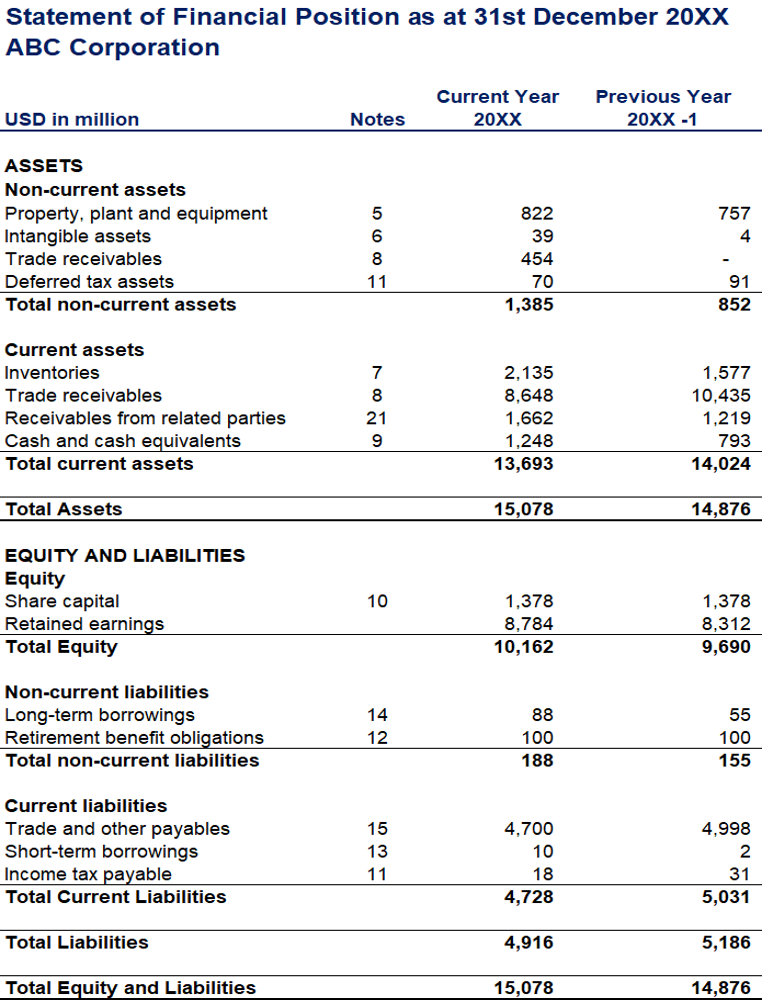

In [7]:
image

In [9]:
!pwd

/root/Balram/Layout_page_classification/prediction


In [49]:
print(len(words))
print(len(boxes))

list(zip(words,boxes))[:5]

129
129


[('R&D', [422, 104, 454, 115]),
 ('R&D', [337, 204, 366, 214]),
 ('QUALITY', [374, 203, 439, 215]),
 ('IMPROVEMENT', [448, 202, 549, 213]),
 ('SUGGESTION/SOLUTION', [334, 216, 510, 229])]

In [46]:

print(len(words))
words

129


['R&D',
 'R&D',
 'QUALITY',
 'IMPROVEMENT',
 'SUGGESTION/SOLUTION',
 'FORM',
 'Name/Phone',
 'Ext.:',
 'M.',
 'Hamann.',
 'P.',
 'Harper.',
 'P.',
 'Martinez',
 'Date:',
 '9/3/92',
 'Supervisor/Manager:',
 'J.',
 'S.',
 'Wigand',
 'R&D',
 'Group:',
 'Licensee',
 'Suggestion:',
 'Discontinue',
 'coal',
 'retention',
 'analyses',
 'on',
 'licensee',
 'submitted',
 'product',
 'samples.',
 '(Note:',
 'Coal',
 'Retention',
 'testing',
 'is',
 'not',
 'performed',
 'by',
 'most',
 'licensees.',
 'Other',
 'B&W',
 'physical',
 'measurements',
 'as',
 'ends',
 'stability',
 'and',
 'inspection',
 'for',
 'soft',
 'spots',
 'in',
 'cigarettes',
 'are',
 'thought',
 'to',
 'be',
 'sufficient',
 'measures',
 'to',
 'assure',
 'cigarette',
 'physical',
 'integrity.',
 'The',
 'proposed',
 'action',
 'will',
 'increase',
 'laboratory',
 'productivity.)',
 'Suggested',
 'Solution(s):',
 'Delete',
 'coal',
 'retention',
 'from',
 'the',
 'list',
 'of',
 'standard',
 'analyses',
 'performed',
 'on',


In [45]:
print(len(boxes))
boxes

129


[[422, 104, 454, 115],
 [337, 204, 366, 214],
 [374, 203, 439, 215],
 [448, 202, 549, 213],
 [334, 216, 510, 229],
 [517, 215, 556, 225],
 [119, 276, 211, 289],
 [221, 275, 265, 286],
 [284, 274, 301, 285],
 [311, 274, 374, 285],
 [385, 273, 402, 284],
 [413, 272, 476, 283],
 [485, 272, 502, 283],
 [513, 271, 587, 282],
 [632, 270, 677, 281],
 [715, 268, 772, 281],
 [122, 316, 295, 330],
 [313, 315, 330, 325],
 [341, 314, 356, 325],
 [367, 314, 425, 326],
 [551, 312, 580, 322],
 [587, 311, 641, 323],
 [671, 310, 745, 320],
 [123, 357, 220, 371],
 [250, 355, 350, 366],
 [360, 354, 397, 365],
 [406, 353, 489, 364],
 [498, 352, 572, 364],
 [581, 354, 601, 362],
 [608, 351, 682, 362],
 [691, 349, 775, 360],
 [250, 369, 314, 382],
 [325, 368, 397, 381],
 [417, 367, 469, 379],
 [489, 366, 526, 376],
 [535, 365, 619, 376],
 [628, 364, 692, 376],
 [702, 363, 719, 373],
 [728, 364, 757, 374],
 [251, 382, 334, 395],
 [342, 381, 362, 394],
 [370, 382, 408, 391],
 [417, 380, 506, 390],
 [526, 379,

In [35]:
#con = AutoConfig.from_pretrained('pytorch_model.bin')

In [36]:
# from transformers import AutoModel 
# #model = AutoModel.from_pretrained('.\model',local_files_only=True)
# #model = AutoModel.from_pretrained('LMV3/pytorch_model.bin',config='LMV3/config.json', local_files_only=True)
# model = AutoModel.from_pretrained('LMV3/config.json', local_files_only=True)